# ICBV-211 Final Project - Language Identification Using OCR

In [1]:
# Imports
import cv2
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from skimage.transform import resize
from sklearn.model_selection import StratifiedShuffleSplit
from skimage.io import imread, imshow
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from collections import Counter

 1. Mount Drive

In [2]:
# Mount on Google Drive
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/ICBV-211 Course Project/ICBV211-123362-Images_ICBV/ICBV211-123362-DatasetForTrain"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. **Example**: Here we can change the input image text for detection

In [3]:
img_path = 'ICBV211-123362-icelandic31.jpg'# input text for laungene recognition, change to other text to test from ICBV-211 Images_ICBV/english or Images_ICBV/german or Images_ICBV/iceland
all_combine_path = "ICBV211-123362-AllSpecialCombine.jpg"# for test

## Data Reading

Here we read the data from Google Drive. We're using the plt.imread(), and tead the image with 3 channels of colors.

**Important Note:** 

The reading part is based on getting the images in seperate directory for each language. If you change the hierarchy, please keep each language in seperate directory.

In [4]:
# Dataset Reading:
imgs_dict_3chan = {}
for lan_dir in os.listdir(dataset_path):
    imgs_dict_3chan[lan_dir] = []
    for font_dir in os.listdir(dataset_path + "/" + lan_dir):
        for img in os.listdir(dataset_path + "/" + lan_dir + "/" + font_dir):
            if "Full" not in img:
                im_path = dataset_path + "/" + lan_dir + "/" + font_dir
                imgs_dict_3chan[lan_dir] = imgs_dict_3chan[lan_dir] + [(plt.imread(im_path + "/" + img), img.split(".")[0])] # Append

## Data Preprocess

The dataset contains all the letters in english, the special letters in german and all the special letters in icelandic. Each image from the dataset got a label:
*   English letters get a label between 100 and 199 (based on the Ascii value).
*   German letters get a label between 200 and 299
*   Icelandic letters get a label between 300 and 399

In this section we are also unify the two directories of english letters.


In [5]:
# Data Preprocess
eng = "English"
ger = "German"
ice = "Icelandic"
lang_dict = {eng: 100, ger: 200, ice: 300}

img_dict_per_lang = {eng: [], ger: [], ice: []}
idx_dict_per_lang = {eng: [], ger: [], ice: []}
for key in imgs_dict_3chan.keys():
    if eng.lower() in key.lower():
        img_dict_per_lang[eng] = img_dict_per_lang[eng] + [img[0] for img in imgs_dict_3chan[key]]
        idx_dict_per_lang[eng] = idx_dict_per_lang[eng] + [img[1] for img in imgs_dict_3chan[key]]
    elif ger.lower() in key.lower():
        img_dict_per_lang[ger] = img_dict_per_lang[ger] + [img[0] for img in imgs_dict_3chan[key]]
        idx_dict_per_lang[ger] = idx_dict_per_lang[ger] + [img[1] for img in imgs_dict_3chan[key]]
    elif ice.lower() in key.lower():
        img_dict_per_lang[ice] = img_dict_per_lang[ice] + [img[0] for img in imgs_dict_3chan[key]]
        idx_dict_per_lang[ice] = idx_dict_per_lang[ice] + [img[1] for img in imgs_dict_3chan[key]]
    else: # Shouldn't happen
        print("oops")
        pass

In [6]:
# Data Preprocess
x_data_3chan = []
y_data_3chan = []
for key in img_dict_per_lang.keys():
    if eng.lower() in key.lower():
        for i in range(len(img_dict_per_lang[key])):
            img = img_dict_per_lang[key][i]
            x_data_3chan = x_data_3chan + [img]
            name = ord(idx_dict_per_lang[key][i][-1])
            name -= 65
            y_data_3chan = y_data_3chan + [lang_dict[eng] + name]
    elif ger.lower() in key.lower():
       for i in range(len(img_dict_per_lang[key])):
            img = img_dict_per_lang[key][i]
            x_data_3chan = x_data_3chan + [img]
            if idx_dict_per_lang[key][i][-2] in "0123456789": 
                name = int(idx_dict_per_lang[key][i][-2:])
            else:
                name = int(idx_dict_per_lang[key][i][-1])
            y_data_3chan = y_data_3chan + [lang_dict[ger] + name]
    elif ice.lower() in key.lower():
        for i in range(len(img_dict_per_lang[key])):
            img = img_dict_per_lang[key][i]
            x_data_3chan = x_data_3chan + [img]
            if idx_dict_per_lang[key][i][-2] in "0123456789": 
                name = int(idx_dict_per_lang[key][i][-2:])
            else:
                name = int(idx_dict_per_lang[key][i][-1])
            y_data_3chan = y_data_3chan + [lang_dict[ice] + name]
    else: # Shouldn't happen
        print("oops")
        pass

In [7]:
# Test
def test_data(x_data, y_data):
    print("Data Size Summary:\n")
    print("x size:", len(x_data))
    print("y size:", len(y_data))
    print("English letters:", len([y for y in y_data if 0 <= y - lang_dict[eng] < 100]))
    print("English labels:", len({y for y in y_data if 0 <= y - lang_dict[eng] < 100}))
    print("German letters:", len([y for y in y_data if 0 <= y - lang_dict[ger] < 100]))
    print("German labels:", len({y for y in y_data if 0 <= y - lang_dict[ger] < 100}))
    print("Icelandic letters:", len([y for y in y_data if 0 <= y - lang_dict[ice] < 100]))
    print("Icelandic labels:", len({y for y in y_data if 0 <= y - lang_dict[ice] < 100}))

In [8]:
test_data(x_data_3chan, y_data_3chan)

Data Size Summary:

x size: 234
y size: 234
English letters: 156
English labels: 52
German letters: 24
German labels: 8
Icelandic letters: 54
Icelandic labels: 18


German Special = 8 letters x 3 fonts = 24

Iclandic Special = (20 letters - 2 that intersect with german) x 3 fonts = 54

Small/Caps English letters = 26 x 3 fonts = 78 (each) => 78 x 2 = 156

### Define Process Functions

#### Convertion to Binary

The below function get's an image and convert it to binary(0/255) based on color.

In [9]:
def to_binary(img):
    new_img = img.copy()
    for row in range(new_img.shape[0]):
        for col in range(new_img.shape[1]):
            if new_img[row][col] <= 127:
                new_img[row][col] = 255
            else:
                new_img[row][col] = 0
    return new_img

The below function get's a binary-image(0/255) and convert it to binary(0/1).

In [10]:
def to_bin_01(bin_img):
    output = bin_img.copy()
    rows, cols = output.shape
    for row in range(rows):
        for col in range(cols):
            if output[row][col] == 255:
                output[row][col] = 1
    return output

The below function get's a binary-image(0/1) and convert it to a format that openCV required

In [11]:
def reverse_bin(bin_image):
    return np.float32(bin_image)

#### Finding Moments

The below function extract the 2nd and 3rd order normalized centralized moments (NCMs). 


In [12]:
def find_moments(img):
    temp = cv2.moments(img)
    output = [temp.get(key) for key in ['nu20', 'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03']]
    return output

#### Special Region Definition

The below function returns the special region (as defined in the project report) of an image. 

In [13]:
def top_pxl(img, k):
    rows, cols = img.shape
    crop_img = img[:k, :]
    return crop_img

#### Comparation Functions

The below function compare to features vectors (using SSD) and return the result.

In [14]:
def ft_comp(f1, f2):
    diff_score = []
    for i in range(len(f1)):
        if f1[i] > f2[i]:
            diff_score = diff_score + [f1[i] - f2[i]]
        else:
            diff_score = diff_score + [f2[i] - f1[i]]
    return float((sum([i**2 for i in diff_score]))) # SSD     

## OCR on Dataset


The below function takes the data set and resize it, 2 times bigger and than activates an OCR on it to cut the white backround.

In [15]:
new_labels = []
filled_list = []
for i in range(len(x_data_3chan)):
  img = x_data_3chan[i]
  img_temp = img

  # change image size
  scale_percent = 200 # percent of original size
  width = int(img_temp.shape[1] * scale_percent / 100)
  height = int(img_temp.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  # gray image
  gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

  # change threshold to white and black only
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

  # find edges with Canny algorithm
  edges = cv2.Canny(thresh,100,200)
  
  # dilate the img
  dilate_img = cv2.dilate(edges, None, iterations=1)
  ret, binery_img = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_OTSU)

  # Copy the thresholded image.
  im_floodfill = binery_img.copy()

  # Mask used to flood filling
  h, w = binery_img.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)

  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);

  # Invert floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)

  # Combine the two images to get the foreground
  filled = binery_img | im_floodfill_inv

  invert = cv2.bitwise_not(filled)
  ret, mask = cv2.threshold(invert, 254, 255, cv2.THRESH_BINARY)
  cv2.waitKey(0)

  # find contours of charecter in an image
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  for contour in contours:

      if cv2.contourArea(contour) < 200:
          continue

      rect = cv2.minAreaRect(contour)
      box = cv2.boxPoints(rect)

      ext_left = tuple(contour[contour[:, :, 0].argmin()][0])
      ext_right = tuple(contour[contour[:, :, 0].argmax()][0])
      ext_top = tuple(contour[contour[:, :, 1].argmin()][0])
      ext_bot = tuple(contour[contour[:, :, 1].argmax()][0])

      roi_corners = np.array([box], dtype=np.int32)

      cv2.polylines(resized, roi_corners, 1, (255, 0, 0), 3)
      cv2.waitKey(0)

      cropped_image = gray[ext_top[1]- 35 :ext_bot[1], ext_left[0]:ext_right[0]]
      fil_crop_img = filled[ext_top[1]- 35 :ext_bot[1], ext_left[0]:ext_right[0]]
     
      h_c = cropped_image.shape
      if h_c[0] > 100:
        filled_list.append(fil_crop_img)
        new_labels.append(y_data_3chan[i])

### Feature Extraction

This below function extract the features for the comparison:



*   First, the function convert the given image to binary.
*   Second, the function finds the moments of the (full) binary image.
*   Then, the function finds the moments of the special region of the binary image.
*   Then, the function skeletonize the full binary image.
*   Then, the function finds the moments of the (full) skeleton image.
*  Then, the function finds the moments of the special region of the skeleton image.
*  At last, the function calculate the "white" pixels of the  special region of the binary image.

Beside the skeletonize and the binary-convertion, the function insert the rest of the results to a feature vector and returns the vector.


In [16]:
def find_feature_vec(img, pad_top):
        bin_img = to_binary(img)
        feature_vec = find_moments(bin_img)
        feature_vec = feature_vec + find_moments(top_pxl(bin_img, pad_top))
        sk_img = reverse_bin(skeletonize(to_bin_01(bin_img)))
        feature_vec = feature_vec + find_moments(sk_img)
        feature_vec = feature_vec + find_moments(top_pxl(sk_img, pad_top))
        tp = top_pxl(bin_img, pad_top)
        rows, cols = tp.shape
        counter = 0
        for row in range(rows):
            for col in range(cols):
                if tp[row][col] == 255:
                    counter += 1
        feature_vec = feature_vec + [counter/(tp.shape[0]*tp.shape[1])]
        return feature_vec

In [17]:
# Finding the features of each letter from the dataset.
features_per_letter = []
for img in filled_list:
    features_per_letter.append(find_feature_vec(img, 35))

ncomp = len(features_per_letter[0])

In [18]:
print("Len of features_per_letter (should be same as dataset = 234): ", len(features_per_letter))
print("Len of each feature vector: ", ncomp)


Len of features_per_letter (should be same as dataset = 234):  234
Len of each feature vector:  29


In [19]:
print("Features comparison between two identical images: ", ft_comp(features_per_letter[0], features_per_letter[0]))
print("Features comparison between two similar images: ", ft_comp(features_per_letter[3], features_per_letter[-19]))

Features comparison between two identical images:  0.0
Features comparison between two similar images:  4.152538692804535


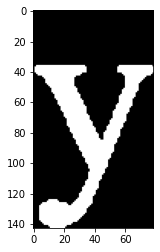

In [20]:
plt.imshow(filled_list[3], cmap="gray")

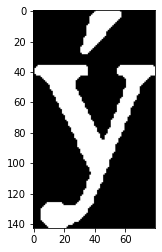

In [21]:
plt.imshow(filled_list[-19], cmap="gray")

We can see that the images are very similar, but the features comparison find a big difference between them.

## OCR on Input Text

The below function gets an image with text of some luange(English/Geramn/Icelandic) and returns each character in the text in a list

In [22]:
def ocr_data(img):  
  letters_list_found = []

  # change image size
  scale_percent = 200 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  # change threshold to white and black only
  ret, thresh = cv2.threshold(resized, 0, 255, cv2.THRESH_OTSU)

  # find edges with Canny algorithm
  edges = cv2.Canny(thresh,100,200)

  # dilate the img
  dilate_img = cv2.dilate(edges, None, iterations=1)

  # change threshold to white and black only

  ret, binery_img = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_OTSU)

  # Copy the thresholded image
  im_floodfill = binery_img.copy()

  # Mask used to flood filling
  h, w = binery_img.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)

  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);

  # Invert floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)

  # Combine the two images to get the foreground.
  filled = binery_img | im_floodfill_inv

  # invert white and black pixels
  invert = cv2.bitwise_not(filled)

  result = img.copy()
  img2 = img.copy()

  # make completely white
  ret, mask = cv2.threshold(invert, 254, 255, cv2.THRESH_BINARY)
  cv2.waitKey(0)

  # find contours of charecter in an image
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  #letters_list_found = []
  for contour in contours:

      if cv2.contourArea(contour) < 200:
          continue

      rect = cv2.minAreaRect(contour)
      box = cv2.boxPoints(rect)

      ext_left = tuple(contour[contour[:, :, 0].argmin()][0])
      ext_right = tuple(contour[contour[:, :, 0].argmax()][0])
      ext_top = tuple(contour[contour[:, :, 1].argmin()][0])
      ext_bot = tuple(contour[contour[:, :, 1].argmax()][0])

      roi_corners = np.array([box], dtype=np.int32)

      cv2.polylines(img, roi_corners, 1, (255, 0, 0), 3)
      cv2.waitKey(0)

      cropped_image = filled[ext_top[1]-35:ext_bot[1], ext_left[0]:ext_right[0]] 
      h_c = cropped_image.shape
      if h_c[0] > 80: 
        letters_list_found.append(cropped_image)
  return letters_list_found

In [23]:
letters_list_found = ocr_data(cv2.imread(img_path, 0)) 

In [24]:
print("Number of letters found: ", len(letters_list_found))

Number of letters found:  180


## Identification of the Language

### Feature Extraction from the Input Text

In [25]:
letter_features = [find_feature_vec(img, 35) for img in letters_list_found]

### Comparison the Text Input to the Dataset

In [26]:
res_labels = []
for feat in letter_features:
    vals_idxs = [(ft_comp(feat, features_per_letter[i]), new_labels[i]) for i in range(len(new_labels))]
    vals = [el[0] for el in vals_idxs]
    tmp = min(vals)
    idxs = [el[1] for el in vals_idxs]
    ans = [vals_idxs[i][1] for i in range(len(vals)) if vals_idxs[i][0] == tmp][0]

    if ans not in [120, 152, 203, 204, 317, 318]: # If not u (or variation)
        res_labels = res_labels + [ans]

### Calculating the Language

In [27]:
# Count Appearences
english = 0
german = 0
iceland = 0
for i in res_labels: 
    if i < 200: 
        english = english +1
    if i > 199 and i < 300: 
        german = german +1
    if i > 299 and i < 400: 
        iceland = iceland +1    

# Identify the language
if 0 <= german <= 1 and 0 <= iceland <= 1:
  print("You have an English text!")
elif german >= iceland:
  print("You have a German text!")
elif german < iceland:
  print("You have an Icelandic text!")
else: # Shouldn't happen
  print("Oops! An error has occurred.")

You have an Icelandic text!


## Helpul Tests Functions (Extra)

In [28]:
# Find the image that correspond with the label 
def img_in_label(label, font=0):
    return filled_list[[i for i in range(len(new_labels)) if new_labels[i] == label][font]]

# Find the features vector of the image that correspond with the label
def feat_in_label(label, font=0):
    return features_per_letter[[i for i in range(len(new_labels)) if new_labels[i] == label][font]]

## Accuracy Test: Special Letters

### German Special Letters

In [29]:
#all_combine_path = "AllSpecialCombine.jpg"
ger_spec_list = ocr_data(cv2.imread(all_combine_path, 0))
letter_features = [find_feature_vec(img, 35) for img in ger_spec_list]
res_labels = []
for feat in letter_features:
    vals_idxs = [(ft_comp(feat, features_per_letter[i]), new_labels[i]) for i in range(len(new_labels))]
    vals = [el[0] for el in vals_idxs]
    tmp = min(vals)
    idxs = [el[1] for el in vals_idxs]
    ans = [vals_idxs[i][1] for i in range(len(vals)) if vals_idxs[i][0] == tmp][0]

    if ans not in [120, 152, 203, 204, 317, 318]: # If not u (or variation)
        res_labels = res_labels + [ans]

In [30]:
print("Number of appearances:")

# Count Appearences
english = 0
german = 0
iceland = 0
for i in res_labels: 
    if i < 200: 
        english = english +1
    if i > 199 and i < 300: 
        german = german +1
    if i > 299 and i < 400: 
        iceland = iceland +1   

print("English, German, Icelandic: ", english, german, iceland)

Number of appearances:
English, German, Icelandic:  1 6 16


Successfull Identification:


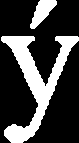

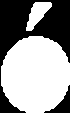

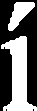

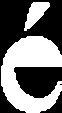

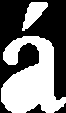

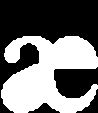

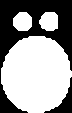

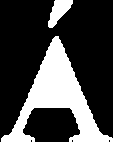

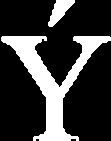

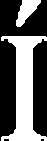

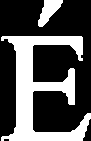

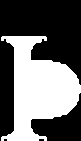

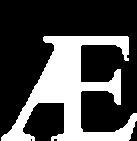

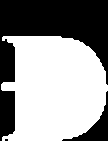

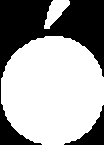

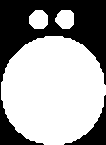

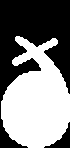

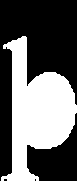

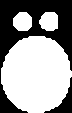

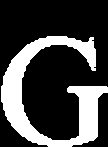

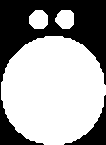

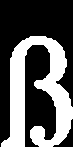

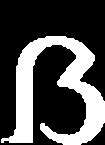

In [31]:
print("Successfull Identification:")
for i in res_labels:
     cv2_imshow(img_in_label(i))

Note: labels 205 and 206 appear twice due to the fact that they appear in both icelandic and german.

Missing Specials:


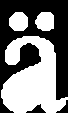

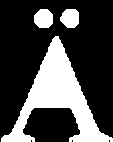

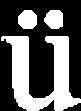

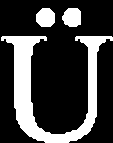

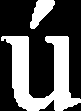

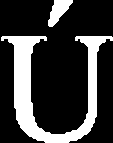

In [32]:
print("Missing Specials:")
mis = {i for i in new_labels if i not in res_labels and i >= 200}
for i in mis:
    cv2_imshow(img_in_label(i))

We can see that beside the "u" variations (that we manually excluded), the only letters that were missing was small a with two dots above it, and capital A with two dots above it. Those together recognized as a G. This is a cropping error(i.e., both letters was counted as one). Due to the fact that this pair is unlikely to appear together, we are fine with that.

## Report Examples Code

### OCR on Data

Edge detection

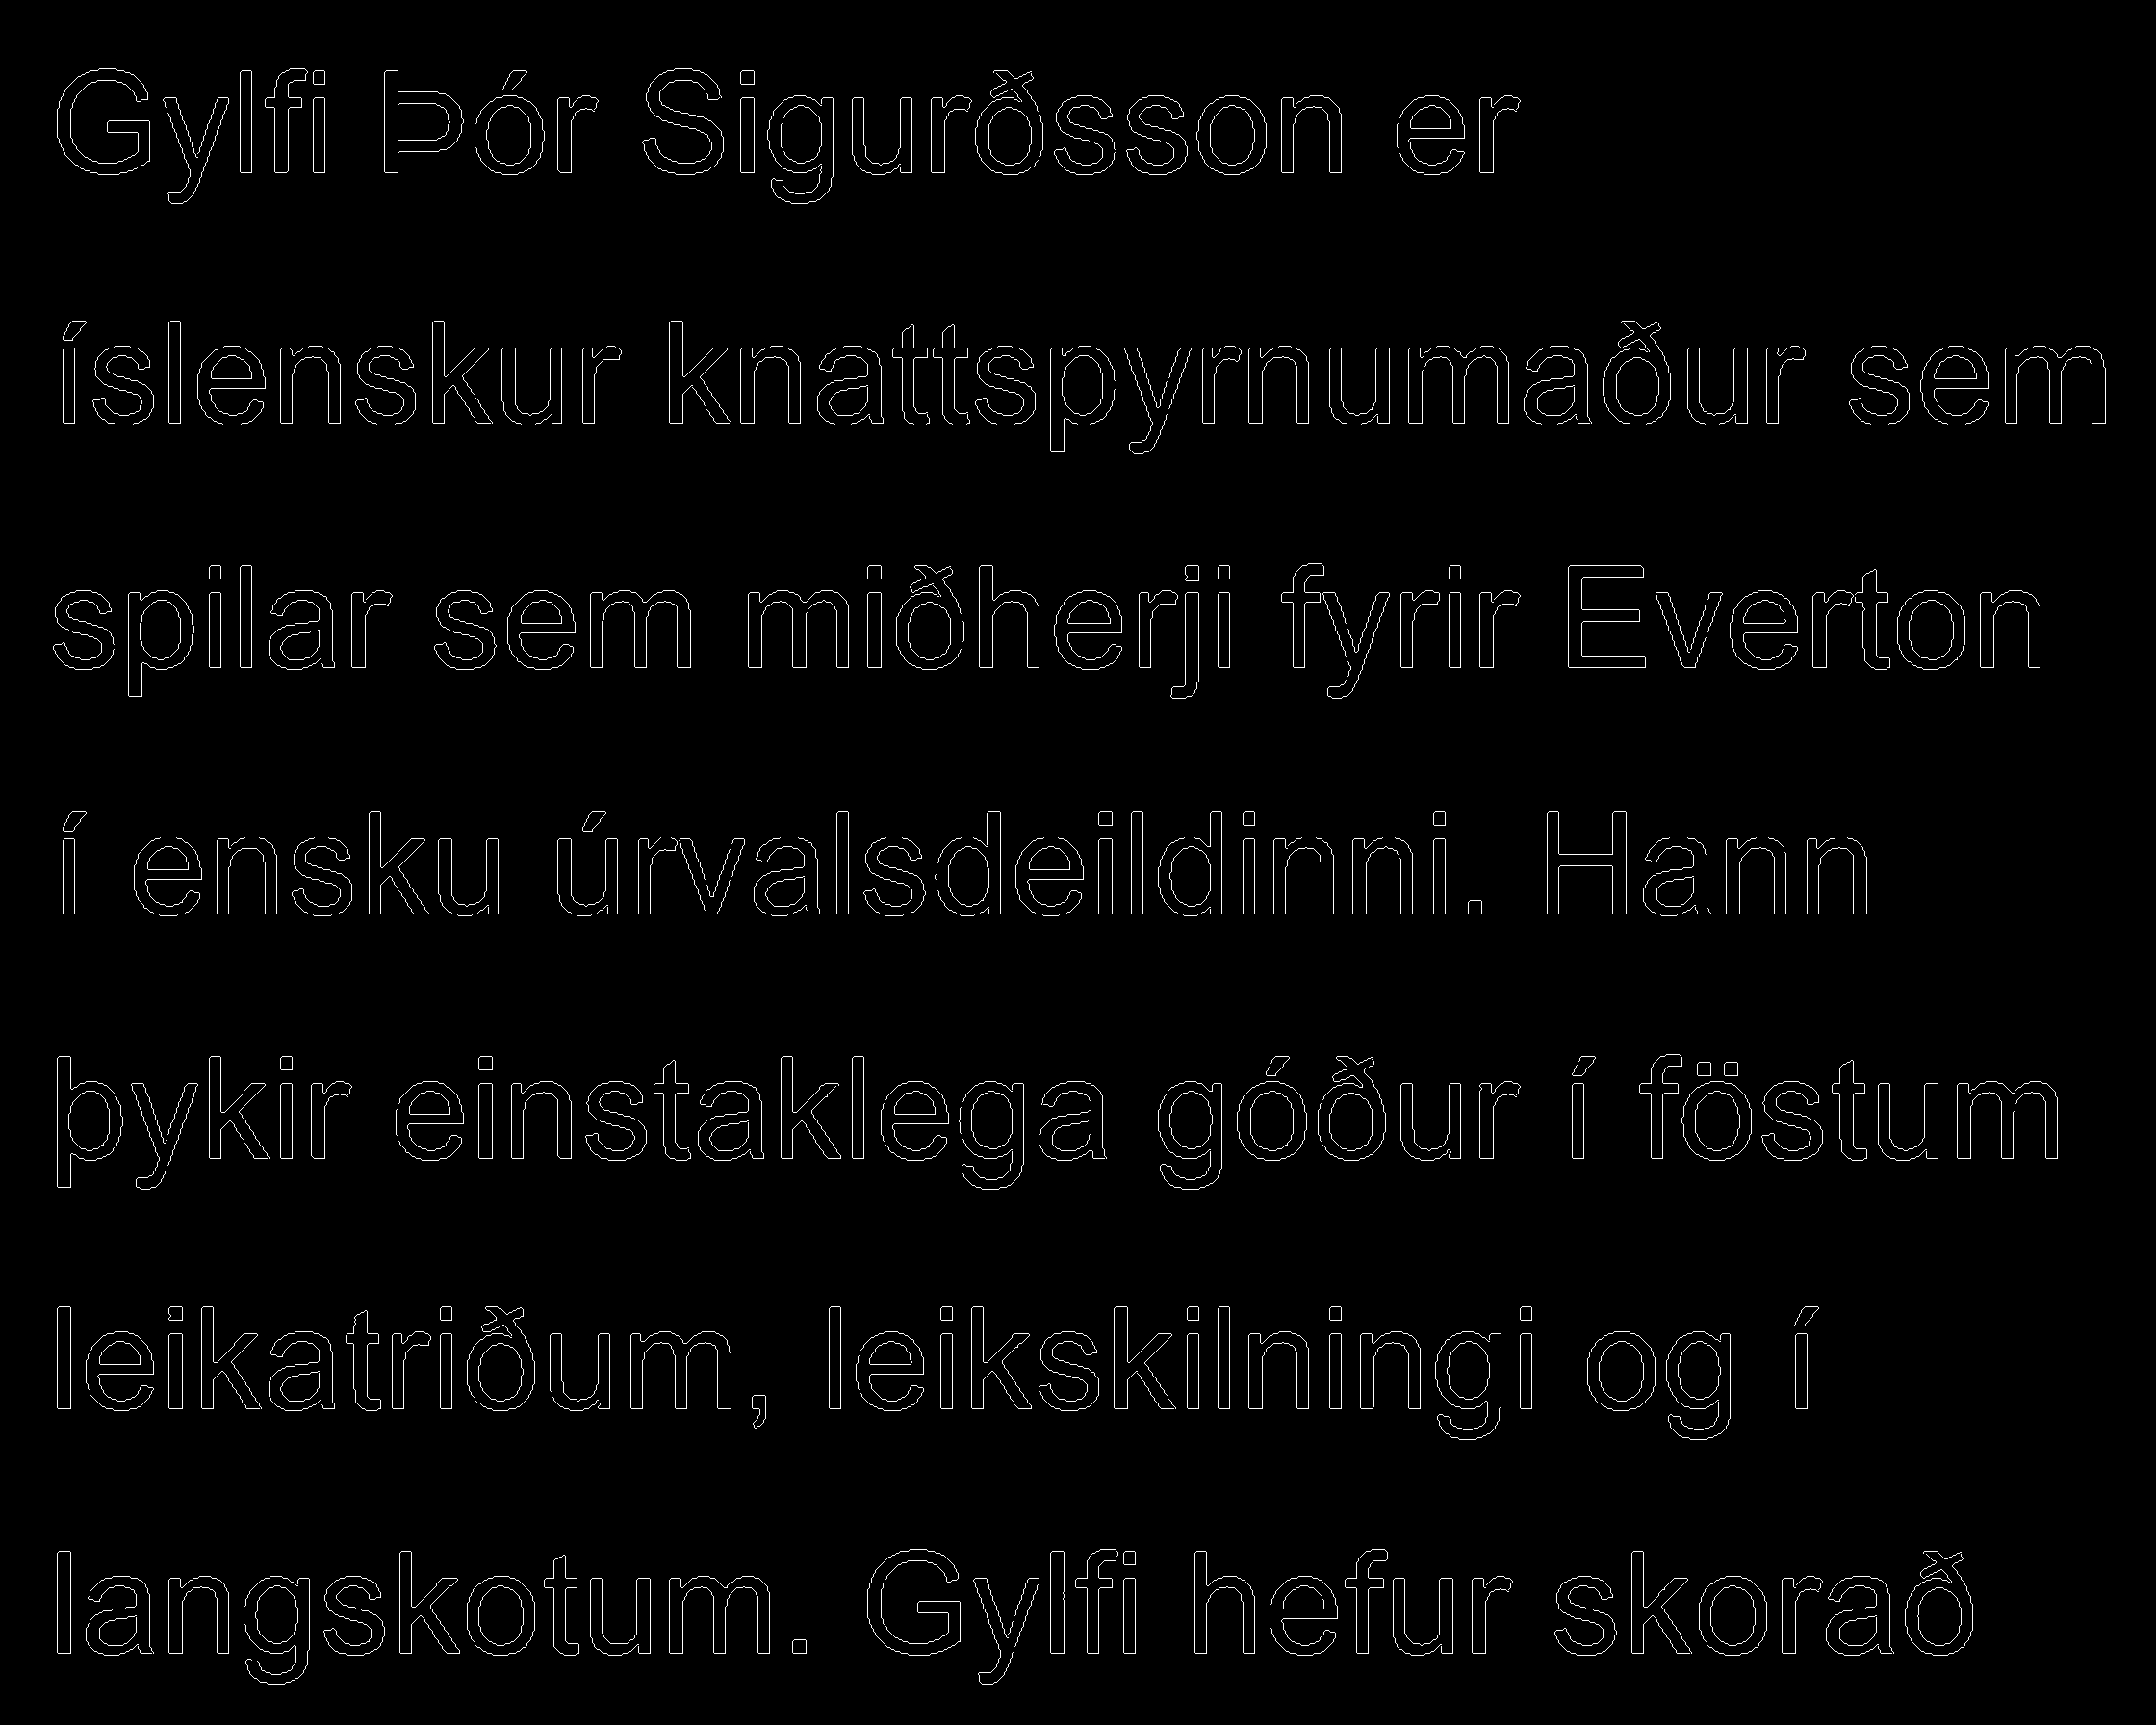

In [33]:
def ocr_data2(img):  

  # change image size
  scale_percent = 200 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  # change threshold to white and black only
  ret, thresh = cv2.threshold(resized, 0, 255, cv2.THRESH_OTSU)

  # find edges with Canny algorithm
  edges = cv2.Canny(thresh,100,200)
  cv2_imshow(edges)
ocr_data2(cv2.imread(img_path, 0))

Dilate image

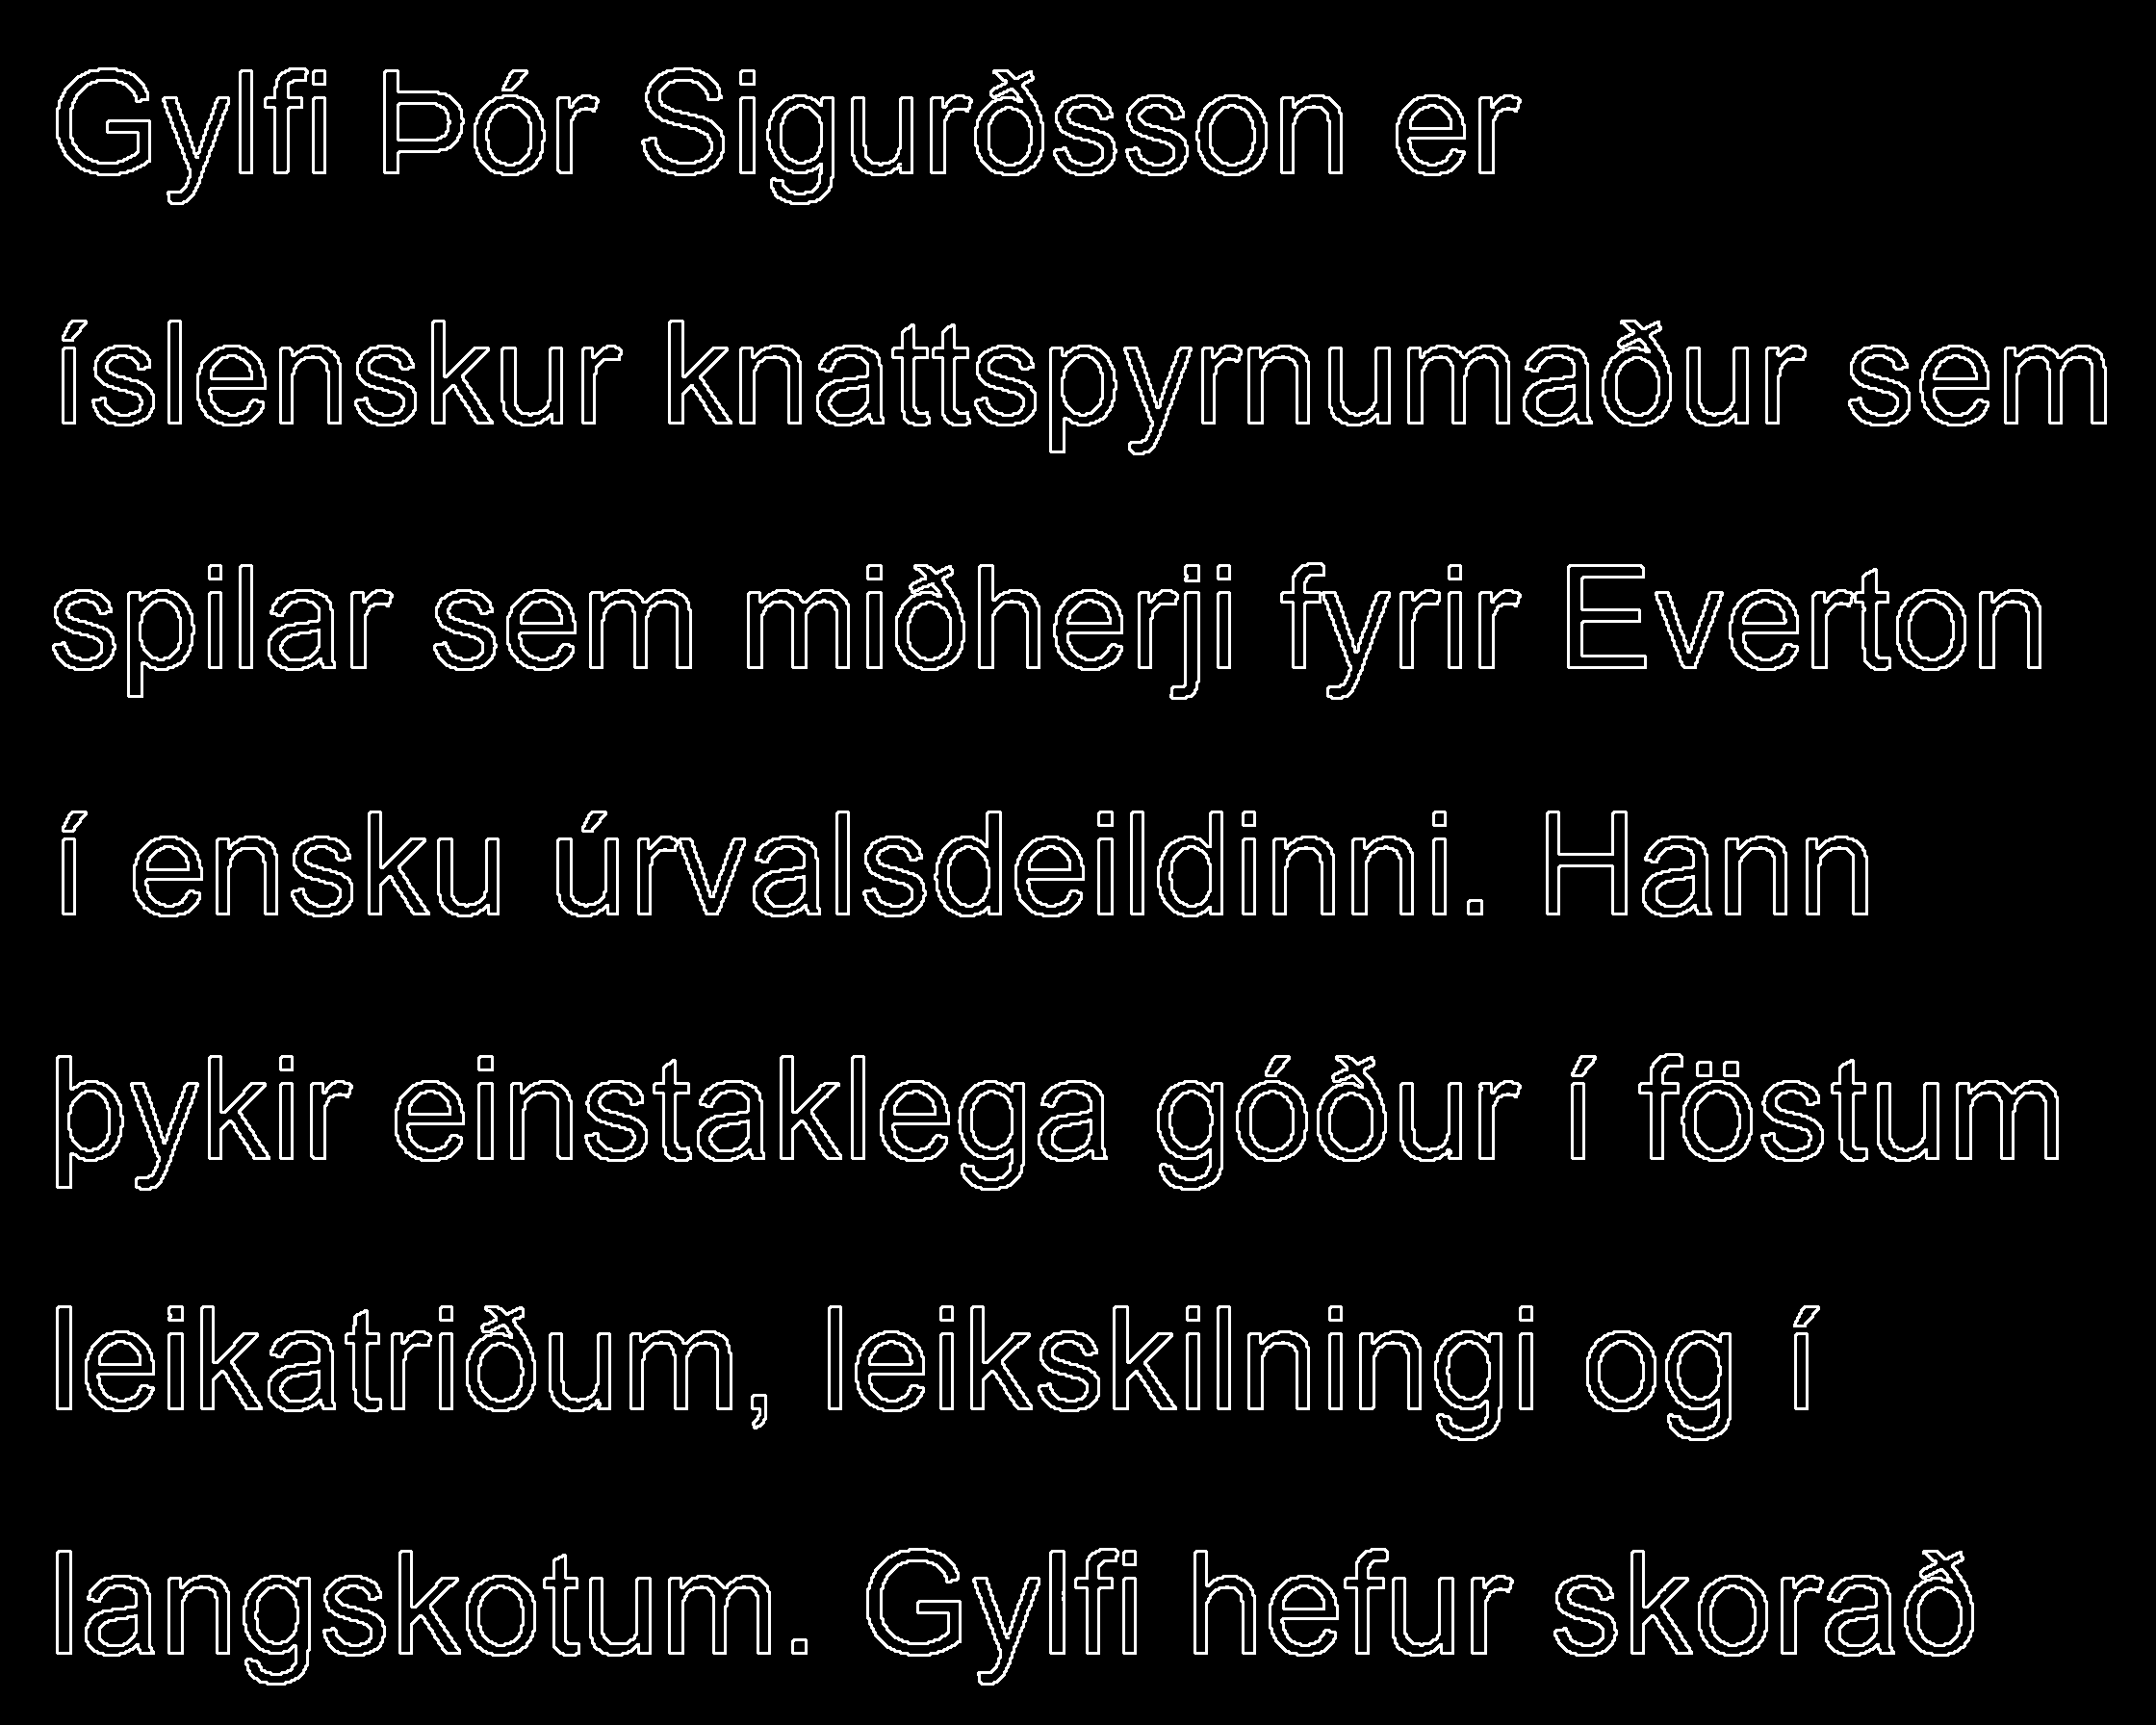

In [34]:
def ocr_data3(img):  
  # change image size
  scale_percent = 200 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  # change threshold to white and black only
  ret, thresh = cv2.threshold(resized, 0, 255, cv2.THRESH_OTSU)

  # find edges with Canny algorithm
  edges = cv2.Canny(thresh,100,200)

  # dilate the img
  dilate_img = cv2.dilate(edges, None, iterations=1)

  cv2_imshow(dilate_img)
ocr_data3(cv2.imread(img_path, 0))

Filled characters and color inverted

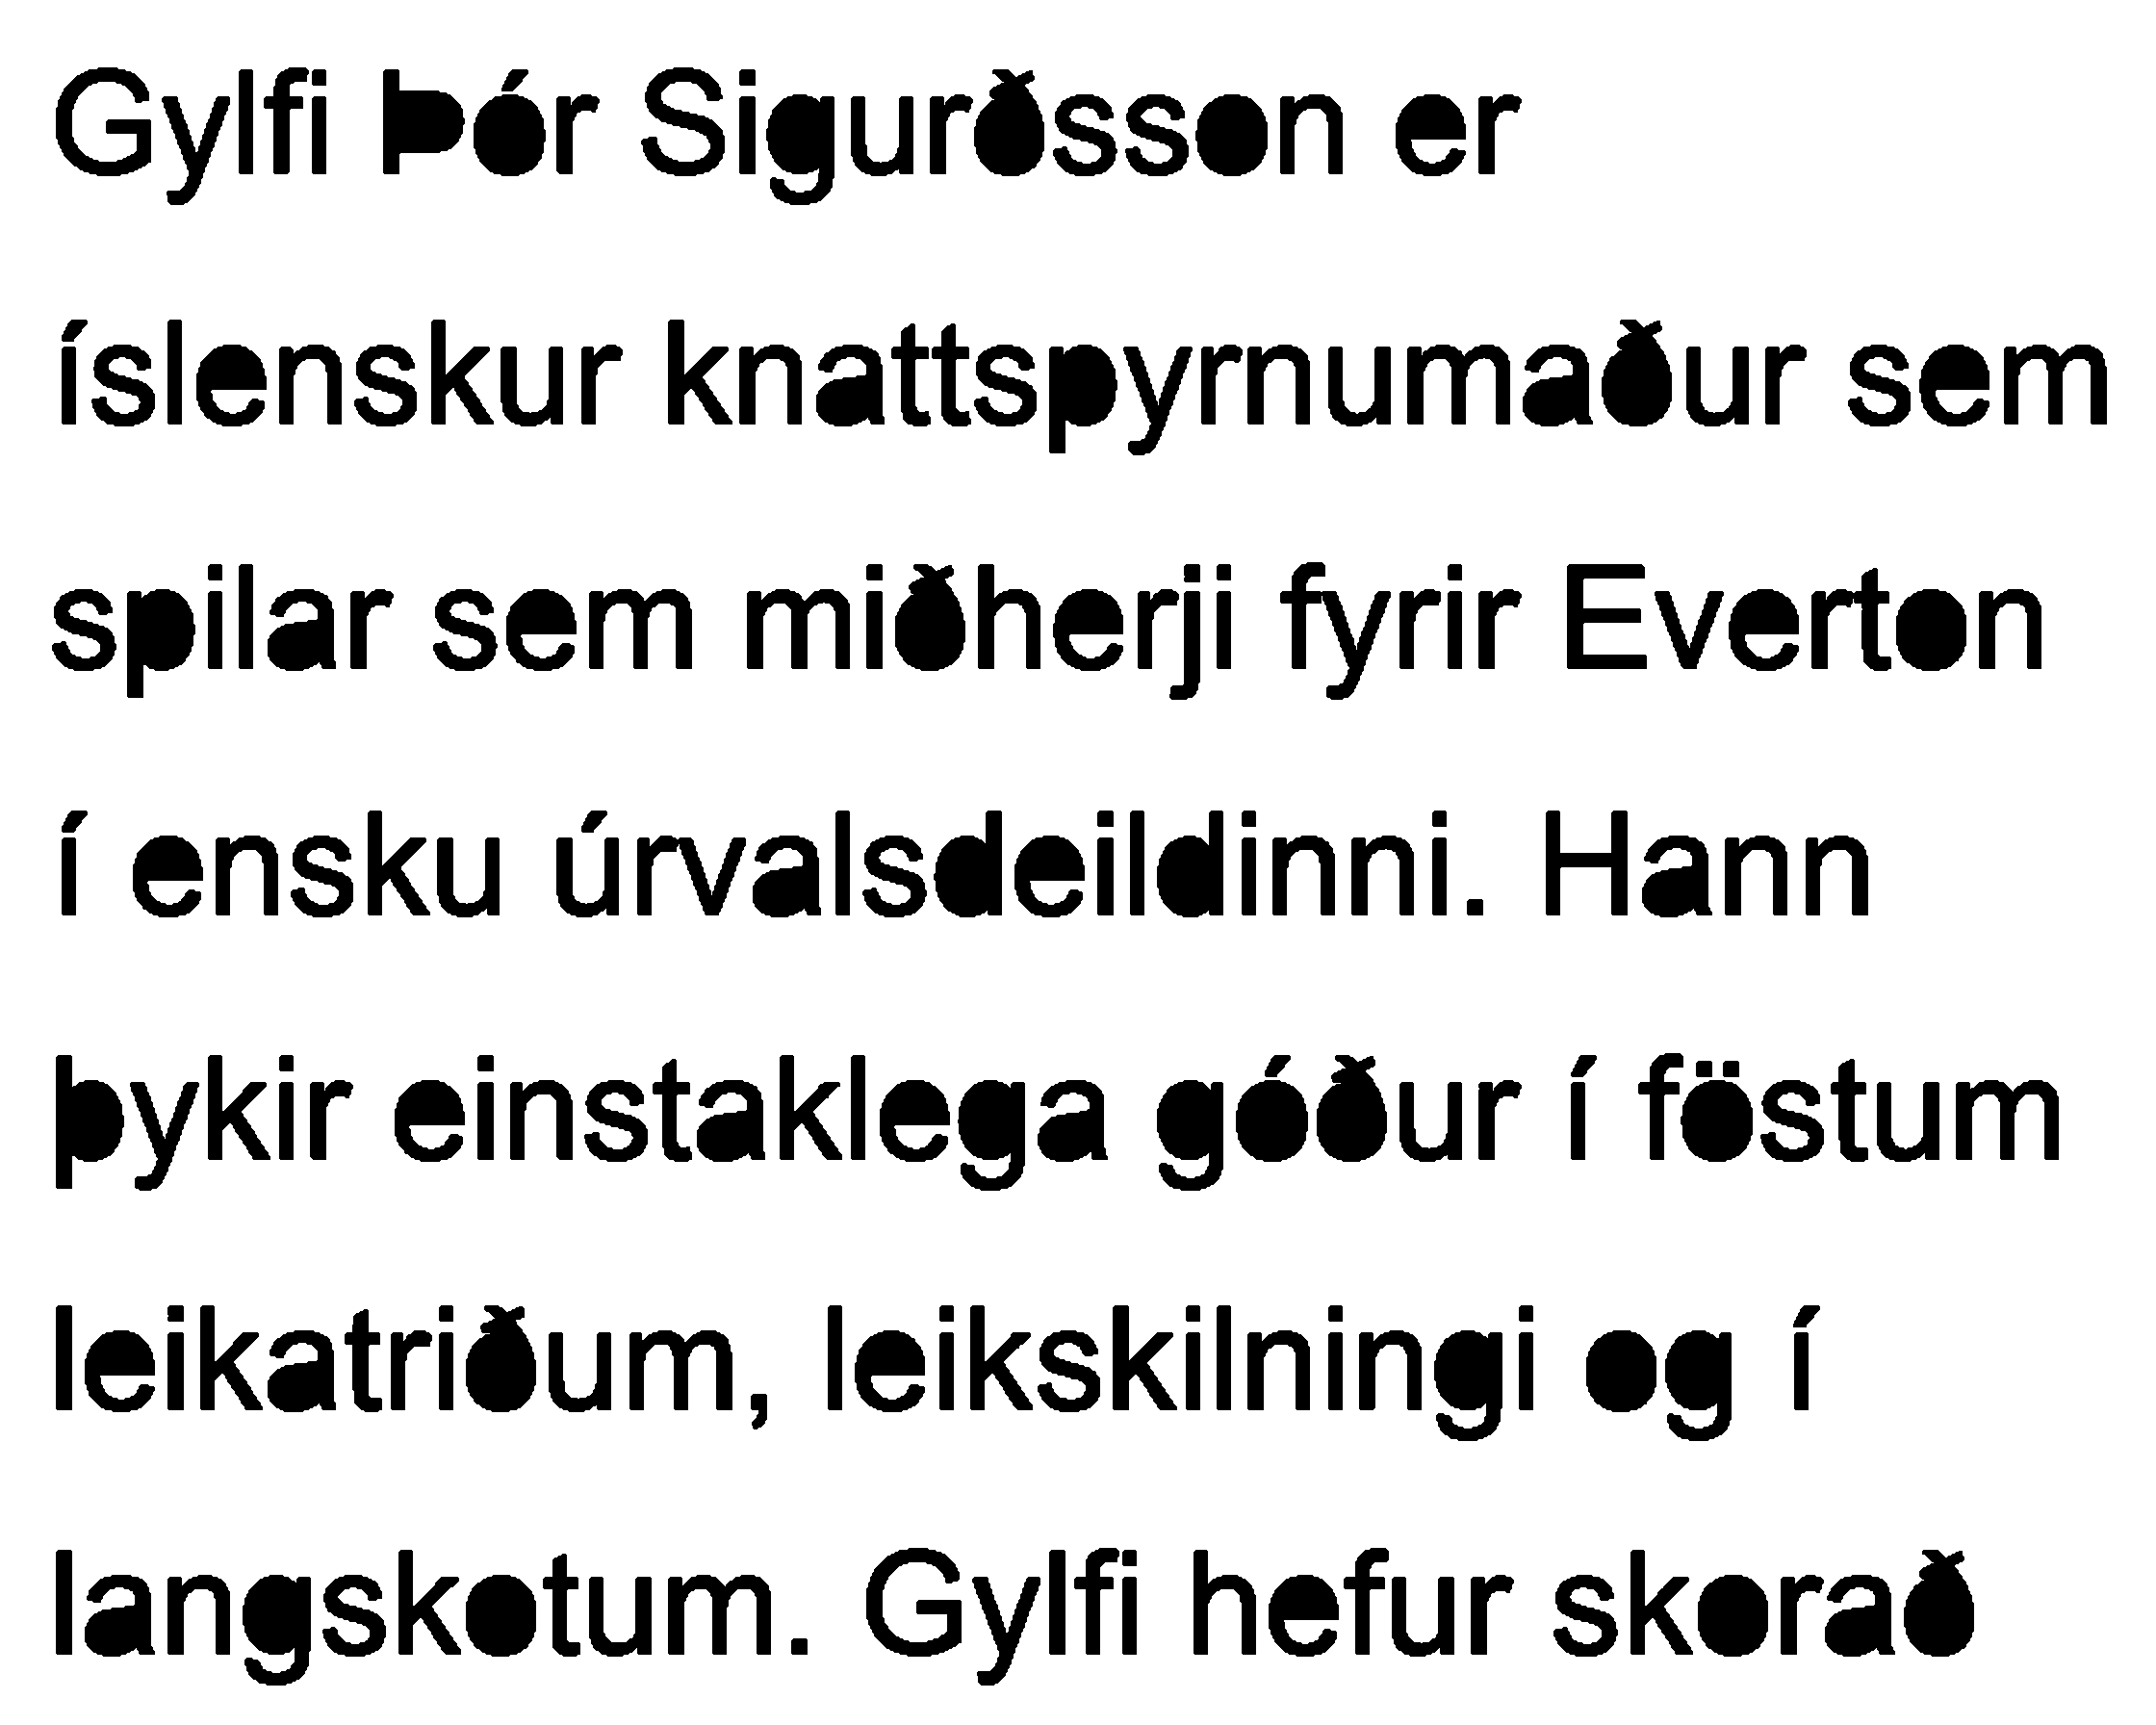

In [35]:
def ocr_data4(img):  
  # change image size
  scale_percent = 200 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  # change threshold to white and black only
  ret, thresh = cv2.threshold(resized, 0, 255, cv2.THRESH_OTSU)

  # find edges with Canny algorithm
  edges = cv2.Canny(thresh,100,200)

  # dilate the img
  dilate_img = cv2.dilate(edges, None, iterations=1)

  # change threshold to white and black only

  ret, binery_img = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_OTSU)

  # Copy the thresholded image
  im_floodfill = binery_img.copy()

  # Mask used to flood filling
  h, w = binery_img.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)

  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);
  
  # Invert floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)

  # Combine the two images to get the foreground.
  filled = binery_img | im_floodfill_inv

  # invert white and black pixels
  invert = cv2.bitwise_not(filled)

  cv2_imshow(invert)

ocr_data4(cv2.imread(img_path, 0))

Final characters from text

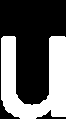

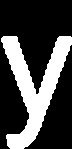

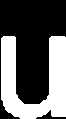

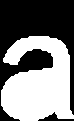

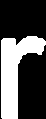

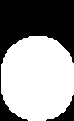

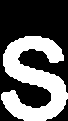

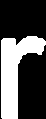

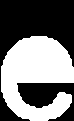

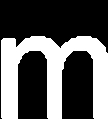

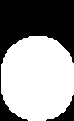

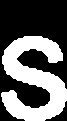

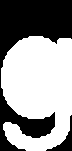

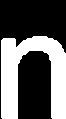

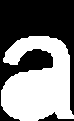

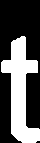

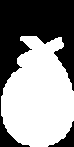

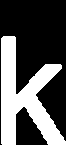

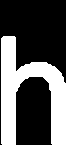

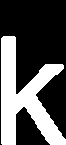

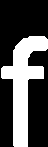

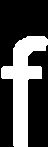

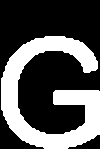

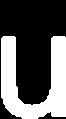

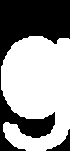

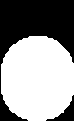

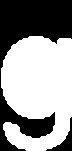

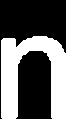

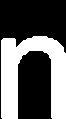

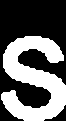

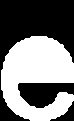

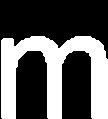

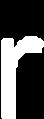

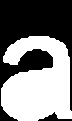

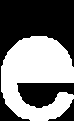

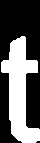

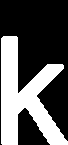

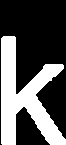

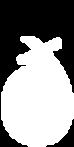

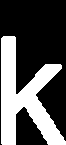

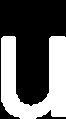

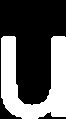

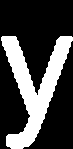

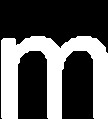

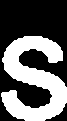

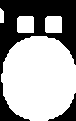

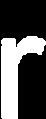

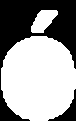

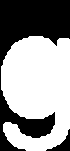

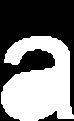

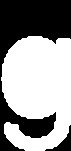

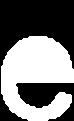

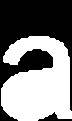

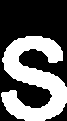

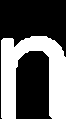

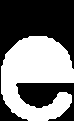

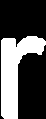

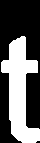

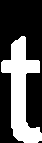

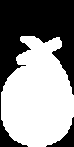

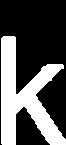

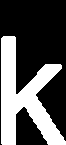

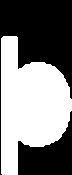

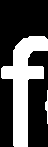

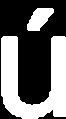

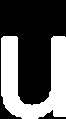

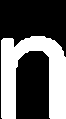

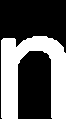

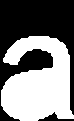

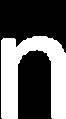

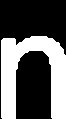

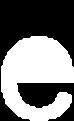

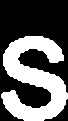

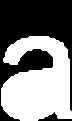

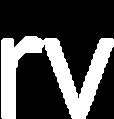

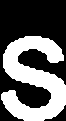

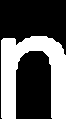

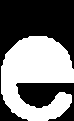

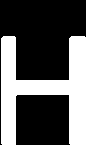

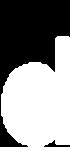

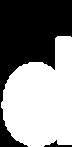

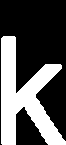

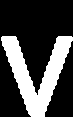

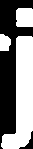

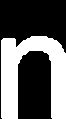

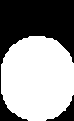

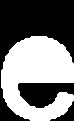

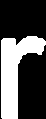

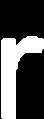

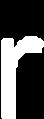

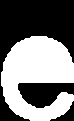

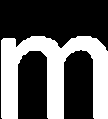

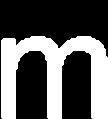

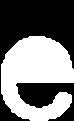

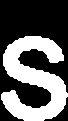

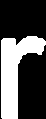

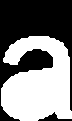

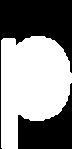

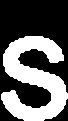

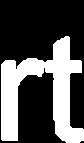

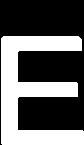

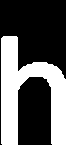

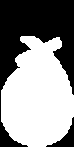

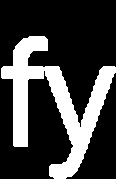

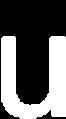

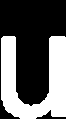

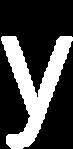

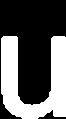

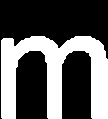

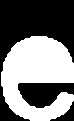

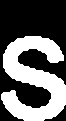

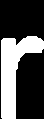

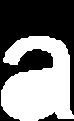

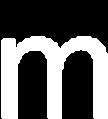

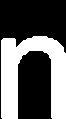

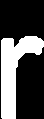

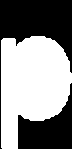

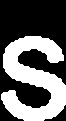

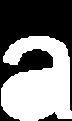

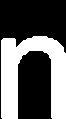

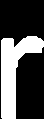

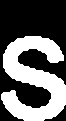

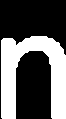

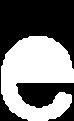

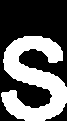

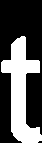

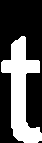

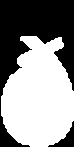

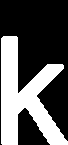

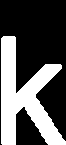

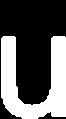

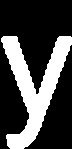

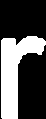

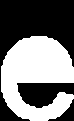

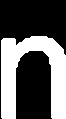

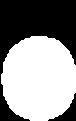

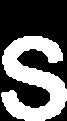

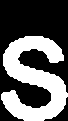

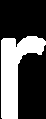

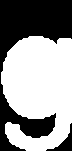

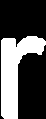

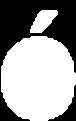

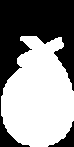

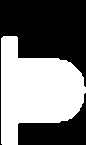

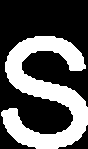

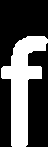

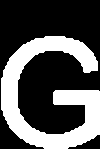

In [36]:
def ocr_data5(img):  
  # change image size
  scale_percent = 200 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  # change threshold to white and black only
  ret, thresh = cv2.threshold(resized, 0, 255, cv2.THRESH_OTSU)

  # find edges with Canny algorithm
  edges = cv2.Canny(thresh,100,200)

  # dilate the img
  dilate_img = cv2.dilate(edges, None, iterations=1)

  # change threshold to white and black only

  ret, binery_img = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_OTSU)

  # Copy the thresholded image
  im_floodfill = binery_img.copy()

  # Mask used to flood filling
  h, w = binery_img.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)

  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);

  # Invert floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)

  # Combine the two images to get the foreground.
  filled = binery_img | im_floodfill_inv

  # invert white and black pixels
  invert = cv2.bitwise_not(filled)

  result = img.copy()
  img2 = img.copy()

  # make completely white
  ret, mask = cv2.threshold(invert, 254, 255, cv2.THRESH_BINARY)
  cv2.waitKey(0)

  # find contours of charecter in an image
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  #letters_list_found = []
  for contour in contours:

      if cv2.contourArea(contour) < 200:
          continue

      rect = cv2.minAreaRect(contour)
      box = cv2.boxPoints(rect)

      ext_left = tuple(contour[contour[:, :, 0].argmin()][0])
      ext_right = tuple(contour[contour[:, :, 0].argmax()][0])
      ext_top = tuple(contour[contour[:, :, 1].argmin()][0])
      ext_bot = tuple(contour[contour[:, :, 1].argmax()][0])

      roi_corners = np.array([box], dtype=np.int32)

      cv2.polylines(img, roi_corners, 1, (255, 0, 0), 3)
      cv2.waitKey(0)

      cropped_image = filled[ext_top[1]-35:ext_bot[1], ext_left[0]:ext_right[0]] 
      h_c = cropped_image.shape
      if h_c[0] > 80: 
        letters_list_found.append(cropped_image)
        cv2_imshow(cropped_image)

ocr_data5(cv2.imread(img_path, 0))

### Skeletonize Moments

First letter: english 'p'


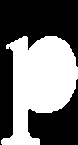

Second letter: icelandic special


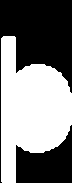

Moments difference:  1.366909770418267e-08


In [37]:
lett = img_in_label(147, 1)
special_lett = img_in_label(307, 2)
print("First letter: english \'p\'")
cv2_imshow(lett)
print("Second letter: icelandic special")
cv2_imshow(special_lett)
print("Moments difference: ", ft_comp(find_moments(lett), find_moments(special_lett)))

First letter Skeleton: english 'p'


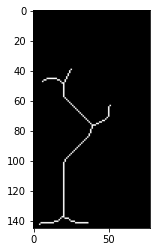

In [38]:
lett = skeletonize(to_bin_01(img_in_label(147, 1)))
special_lett = skeletonize(to_bin_01(img_in_label(307, 2)))
print("First letter Skeleton: english \'p\'")
plt.imshow(reverse_bin(lett), cmap='gray')

Second letter Skeleton: icelandic special


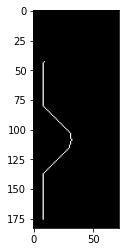

In [39]:
print("Second letter Skeleton: icelandic special")
plt.imshow(reverse_bin(special_lett), cmap='gray')

In [40]:
print("Moments difference: ", ft_comp(find_moments(reverse_bin(lett)), find_moments(reverse_bin(special_lett))))

Moments difference:  25.05443477162987


### How Does Special Region looks loke?

Original letter:


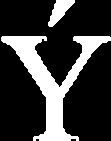

The letter special region:


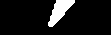

In [41]:
lett = img_in_label(320)
lett_special_region = top_pxl(lett, 35)
print("Original letter:")
cv2_imshow(lett)
print("The letter special region:")
cv2_imshow(lett_special_region)

## Operation Instruction
1. Open the notebook in Google Colab.
2. Mount Drive - The reading part is based on getting the images in a separate directory for each language. If you change the hierarchy, please keep each language in a separate directory. The order you need as we submitted:ICBV211-123362-Images_ICBV/ICBV211-123362-DatasetForTrain for data set to load.
3. Example - load image locally to the notebook. Examples can be found in ICBV211-123362-Images_ICBV/ICBV211-123362-english or ICBV211-123362-Images_ICBV/ICBV211-123362-german or ICBV211-123362-Images_ICBV/ICBV211-123362-iceland there are images for test language recognition.

4. Run all cells.

5. Calculating the Language - In this cell we can see the result of our language.
